##Importing the Requisite Libraries

In [1]:
import tqdm
import json
import pickle
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Step 1: Load the datasets as dataframes in python using pandas

###Reading the CSV files into a Pandas DataFrame

In [67]:
k_wheat_yield= pd.read_csv('/content/drive/MyDrive/wheat_yield/kansas_wheat_yield.csv')
m_kan_ndvi= pd.read_csv('/content/drive/MyDrive/wheat_yield/monthly_kansas_ndvi.csv')
pre_wheat_yield= pd.read_csv('/content/drive/MyDrive/wheat_yield/predict_kansas_wheat_yield.csv')

In [ ]:
print(k_wheat_yield.shape)
print(m_kan_ndvi.shape)
print(pre_wheat_yield.shape)

(847, 4)
(11928, 5)
(80, 3)


In [ ]:
print(k_wheat_yield.head())
print('='*50)
print(k_wheat_yield.tail())

   Year   State     County  Value
0  2015  KANSAS     BARTON   40.8
1  2015  KANSAS  DICKINSON   46.6
2  2015  KANSAS      ELLIS   32.9
3  2015  KANSAS  ELLSWORTH   36.0
4  2015  KANSAS     MARION   46.3
     Year   State   County  Value
842  2007  KANSAS     NESS   37.0
843  2007  KANSAS    SCOTT   56.0
844  2007  KANSAS    TREGO   30.0
845  2007  KANSAS  WALLACE   46.0
846  2007  KANSAS  WICHITA   55.0


In [ ]:
print(m_kan_ndvi.head())
print('='*50)
print(m_kan_ndvi.tail())

  county  year   state  month      ndvi
0  Allen  2006  Kansas      1  0.479738
1  Allen  2006  Kansas      2  0.481917
2  Allen  2006  Kansas      3  0.583799
3  Allen  2006  Kansas      4  0.766649
4  Allen  2006  Kansas      5  0.685759
        county  year   state  month      ndvi
11923  Woodson  2016  Kansas      8  0.555184
11924  Woodson  2016  Kansas      9  0.500916
11925  Woodson  2016  Kansas     10  0.382120
11926  Woodson  2016  Kansas     11  0.362114
11927  Woodson  2016  Kansas     12  0.274107


In [ ]:
print(pre_wheat_yield.head())

   Year   State     County
0  2016  KANSAS     BARTON
1  2016  KANSAS  DICKINSON
2  2016  KANSAS      ELLIS
3  2016  KANSAS    LINCOLN
4  2016  KANSAS     MARION


###Exploratory Data Analysis

In [ ]:
print("Number of Unique County Values:",len(np.unique(m_kan_ndvi['county'])))
print("Number of Unique Year Values:",len(np.unique(m_kan_ndvi['year'])))
print("Number of Unique State Values:",len(np.unique(m_kan_ndvi['state'])))

Number of Unique County Values: 103
Number of Unique Year Values: 11
Number of Unique State Values: 1


In [ ]:
print("Starting Year",m_kan_ndvi['year'].min())
print("Last Year",m_kan_ndvi['year'].max())

Starting Year 2006
Last Year 2016


In [ ]:
print(m_kan_ndvi.groupby('year')['month'].min())
print(m_kan_ndvi.groupby('year')['month'].max())

year
2006    1
2007    1
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    1
2016    1
Name: month, dtype: int64
year
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
Name: month, dtype: int64


In [ ]:
print(m_kan_ndvi.groupby('year')['month'].nunique())

year
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
Name: month, dtype: int64


##Step 2: Create a new dataset from the monthly_kansas_ndvi one with crop stage features

In [ ]:
col_names=['county','state','year','ndvi_9_p','ndvi_10_p','ndvi_11_p','ndvi_12_p','ndvi_1_c','ndvi_2_c','ndvi_3_c','ndvi_4_c','ndvi_5_c','ndvi_6_c','ndvi_7_c','ndvi_8_c']

In [ ]:
new_df= pd.DataFrame(columns=col_names)
print(new_df.head())

Empty DataFrame
Columns: [county, state, year, ndvi_9_p, ndvi_10_p, ndvi_11_p, ndvi_12_p, ndvi_1_c, ndvi_2_c, ndvi_3_c, ndvi_4_c, ndvi_5_c, ndvi_6_c, ndvi_7_c, ndvi_8_c]
Index: []


In [ ]:
new_df_dup= pd.merge(new_df,m_kan_ndvi,left_on=['county','state','year'], right_on=['county','state','year'],how='outer')
print(new_df_dup.shape)
print(new_df_dup.head())
print("="*100)
new_df_dup.drop(['month','ndvi'], axis=1,inplace=True)
print(new_df_dup.shape)
print(new_df_dup.head())

(11928, 17)
  ndvi_9_p ndvi_10_p ndvi_11_p ndvi_12_p  ...  year   state month      ndvi
0      NaN       NaN       NaN       NaN  ...  2006  Kansas     1  0.479738
1      NaN       NaN       NaN       NaN  ...  2006  Kansas     2  0.481917
2      NaN       NaN       NaN       NaN  ...  2006  Kansas     3  0.583799
3      NaN       NaN       NaN       NaN  ...  2006  Kansas     4  0.766649
4      NaN       NaN       NaN       NaN  ...  2006  Kansas     5  0.685759

[5 rows x 17 columns]
(11928, 15)
  ndvi_9_p ndvi_10_p ndvi_11_p ndvi_12_p  ... ndvi_8_c county  year   state
0      NaN       NaN       NaN       NaN  ...      NaN  Allen  2006  Kansas
1      NaN       NaN       NaN       NaN  ...      NaN  Allen  2006  Kansas
2      NaN       NaN       NaN       NaN  ...      NaN  Allen  2006  Kansas
3      NaN       NaN       NaN       NaN  ...      NaN  Allen  2006  Kansas
4      NaN       NaN       NaN       NaN  ...      NaN  Allen  2006  Kansas

[5 rows x 15 columns]


In [ ]:
new_df= new_df_dup.drop_duplicates()
print(new_df.shape)
print(new_df.head())

(994, 15)
   ndvi_9_p ndvi_10_p ndvi_11_p ndvi_12_p  ... ndvi_8_c county  year   state
0       NaN       NaN       NaN       NaN  ...      NaN  Allen  2006  Kansas
12      NaN       NaN       NaN       NaN  ...      NaN  Allen  2007  Kansas
24      NaN       NaN       NaN       NaN  ...      NaN  Allen  2008  Kansas
36      NaN       NaN       NaN       NaN  ...      NaN  Allen  2009  Kansas
48      NaN       NaN       NaN       NaN  ...      NaN  Allen  2011  Kansas

[5 rows x 15 columns]


In [ ]:
county= m_kan_ndvi['county'].unique()
print(len(county))
print(county[:5])

103
['Allen' 'Anderson' 'Atchison' 'Barber' 'Barton']


In [ ]:
cols=['ndvi_9_p','ndvi_10_p','ndvi_11_p','ndvi_12_p','ndvi_1_c','ndvi_2_c','ndvi_3_c','ndvi_4_c','ndvi_5_c','ndvi_6_c','ndvi_7_c','ndvi_8_c']

grp_data= m_kan_ndvi.groupby('county')

for c in county:
    cny= grp_data.get_group(c)
    years= np.sort(cny['year'].unique())
    
    for y in range(0,len(years)):
        ndval= np.zeros(12)
        
        if y==0:
            ndval[4:]=cny[(cny.year==years[y])]['ndvi'][4:]
            new_df.loc[(new_df.county==c) & (new_df.year==years[y]),cols]= ndval.tolist()
            
        elif years[y]-years[y-1]==1:
            ndval= cny[(cny.year==years[y]) | (cny.year==years[y-1])]['ndvi'][8:20]
            new_df.loc[(new_df.county==c) & (new_df.year==years[y]),cols]= ndval.tolist()
            #print(ndval)
            #print(new_df.loc[(new_df.county==c) & (new_df.year==years[y]),cols])
            #print('='*50)
        elif years[y]-years[y-1]>1:
            ndval[4:]= cny[(cny.year==years[y])]['ndvi'][4:]
            new_df.loc[(new_df.county==c) & (new_df.year==years[y]),cols]=ndval.tolist()

In [ ]:
print(new_df.shape)
new_df.tail(10)

(994, 15)


,ndvi_9_p,ndvi_10_p,ndvi_11_p,ndvi_12_p,ndvi_1_c,ndvi_2_c,ndvi_3_c,ndvi_4_c,ndvi_5_c,ndvi_6_c,ndvi_7_c,ndvi_8_c,county,year,state
11808,0.433583,0.389563,0.334313,0.311548,0.375585,0.334522,0.38353,0.600347,0.692492,0.490459,0.50674,0.41745,Wilson,2014,Kansas
11820,0.407786,0.487826,0.484306,0.317936,0.314891,0.32362,0.403917,0.688535,0.766486,0.587203,0.531406,0.573453,Wilson,2015,Kansas
11832,0.485683,0.377836,0.343716,0.378788,0.511248,0.518311,0.657861,0.815562,0.692559,0.480719,0.549363,0.559335,Wilson,2016,Kansas
11844,0,0,0,0,0.73046,0.459943,0.479729,0.471549,0.403947,0.34716,0.335438,0.348899,Woodson,2006,Kansas
11856,0.403947,0.34716,0.335438,0.348899,0.512199,0.466748,0.60625,0.789857,0.65668,0.593639,0.608545,0.550573,Woodson,2007,Kansas
11868,0.420609,0.466688,0.406534,0.332391,0.491925,0.503064,0.542989,0.723394,0.786553,0.571819,0.582675,0.650162,Woodson,2008,Kansas
11880,0,0,0,0,0.847694,0.58646,0.523449,0.541046,0.422721,0.417583,0.383502,0.340031,Woodson,2013,Kansas
11892,0.422721,0.417583,0.383502,0.340031,0.48604,0.442799,0.50549,0.755709,0.793052,0.517675,0.414486,0.370422,Woodson,2014,Kansas
11904,0.377423,0.511075,0.427901,0.338578,0.264121,0.282927,0.338403,0.667764,0.761142,0.616036,0.479831,0.449855,Woodson,2015,Kansas
11916,0.411875,0.33749,0.329287,0.321839,0.535401,0.571612,0.722997,0.789714,0.690085,0.407261,0.542842,0.555184,Woodson,2016,Kansas


In [ ]:
new_df.to_json('fin_df.json',orient='split',compression='infer',index='true')

In [ ]:
new_df = pd.read_json('/content/drive/MyDrive/wheat_yield/fin_df.json', orient ='split', compression = 'infer')

In [ ]:
new_df.rename(columns={'county':'County','year':'Year','state':'State'},inplace=True)

In [ ]:
new_df['County']= new_df['County'].str.upper()
new_df['State']= new_df['State'].str.upper()

In [ ]:
comm_cols=['County','Year','State']

In [ ]:
fin_df= pd.merge(k_wheat_yield,new_df, left_on= comm_cols, right_on= comm_cols, how='left')

In [ ]:
print(fin_df.shape)
fin_df.head()

(847, 16)


,Year,State,County,Value,ndvi_9_p,ndvi_10_p,ndvi_11_p,ndvi_12_p,ndvi_1_c,ndvi_2_c,ndvi_3_c,ndvi_4_c,ndvi_5_c,ndvi_6_c,ndvi_7_c,ndvi_8_c
0,2015,KANSAS,BARTON,40.8,0.338849,0.391165,0.451223,0.392530,0.324666,0.362771,0.446360,0.595697,0.728451,0.525577,0.400753,0.373124
1,2015,KANSAS,DICKINSON,46.6,0.357407,0.415897,0.461780,0.427324,0.308040,0.338315,0.426020,0.647146,0.753817,0.524223,0.425291,0.411547
2,2015,KANSAS,ELLIS,32.9,0.300836,0.311549,0.295046,0.275131,0.275688,0.305663,0.357470,0.498296,0.623280,0.425976,0.350579,0.356244
3,2015,KANSAS,ELLSWORTH,36.0,0.343467,0.394788,0.424950,0.409104,0.321815,0.352640,0.418196,0.586401,0.739726,0.557328,0.420357,0.382062
4,2015,KANSAS,MARION,46.3,0.372641,0.443133,0.494328,0.446400,0.357330,0.388718,0.490782,0.714850,0.766586,0.504213,0.449475,0.425091


In [ ]:
Y= fin_df['Value']
fin_df.drop(['Value'], axis=1,inplace=True)
print(len(Y))
print(fin_df.shape)

847
(847, 15)


In [ ]:
train_x,cv_x,train_y,cv_y= train_test_split(fin_df,Y, test_size=0.3,random_state=42)
print(train_x.shape)
print(cv_x.shape)
print(train_y.shape)
print(cv_y.shape)

(592, 15)
(255, 15)
(592,)
(255,)


In [ ]:
cols=['ndvi_9_p','ndvi_10_p','ndvi_11_p','ndvi_12_p','ndvi_1_c','ndvi_2_c','ndvi_3_c','ndvi_4_c','ndvi_5_c','ndvi_6_c','ndvi_7_c','ndvi_8_c']

for col in cols:
    train_x[col] = train_x.groupby('County')[col].transform(lambda x: x.fillna(x.mean()))
    cv_x[col] = cv_x.groupby('County')[col].transform(lambda x: x.fillna(train_x.groupby('County').mean()[col]))

    train_x[col]= train_x[col].fillna(train_x[col].mean())
    cv_x[col]= cv_x[col].fillna(train_x[col].mean())


In [ ]:
print(train_x.isna().sum())
print('='*50)
print(cv_x.isna().sum())

Year         0
State        0
County       0
ndvi_9_p     0
ndvi_10_p    0
ndvi_11_p    0
ndvi_12_p    0
ndvi_1_c     0
ndvi_2_c     0
ndvi_3_c     0
ndvi_4_c     0
ndvi_5_c     0
ndvi_6_c     0
ndvi_7_c     0
ndvi_8_c     0
dtype: int64
Year         0
State        0
County       0
ndvi_9_p     0
ndvi_10_p    0
ndvi_11_p    0
ndvi_12_p    0
ndvi_1_c     0
ndvi_2_c     0
ndvi_3_c     0
ndvi_4_c     0
ndvi_5_c     0
ndvi_6_c     0
ndvi_7_c     0
ndvi_8_c     0
dtype: int64


In [ ]:
train_x.to_json('/content/drive/MyDrive/wheat_yield/train_x.json',orient='split',compression='infer',index='true')
cv_x.to_json('/content/drive/MyDrive/wheat_yield/cv_x.json',orient='split',compression='infer',index='true')
train_y.to_json('/content/drive/MyDrive/wheat_yield/train_y.json',lines=True, orient='records')
cv_y.to_json('/content/drive/MyDrive/wheat_yield/cv_y.json',lines=True, orient='records')

In [35]:
train_x = pd.read_json('/content/drive/MyDrive/wheat_yield/train_x.json', orient ='split', compression = 'infer')
cv_x = pd.read_json('/content/drive/MyDrive/wheat_yield/cv_x.json', orient ='split', compression = 'infer')
train_y = pd.read_json('/content/drive/MyDrive/wheat_yield/train_y.json', lines=True, orient='records')
cv_y = pd.read_json('/content/drive/MyDrive/wheat_yield/cv_y.json', lines=True, orient='records')

In [4]:
print(train_x.shape)
print(cv_x.shape)
print(train_y.shape)
print(cv_y.shape)

(592, 15)
(255, 15)
(592, 1)
(255, 1)


In [36]:
train_x.drop(['State'],axis=1, inplace= True)
cv_x.drop(['State'],axis=1, inplace= True)

In [37]:
tr_year_dum= pd.get_dummies(train_x['Year'])
train_x= pd.concat([train_x,tr_year_dum],axis=1)

cv_year_dum= pd.get_dummies(cv_x['Year'])
cv_year_dum= cv_year_dum.reindex(columns= tr_year_dum.columns,fill_value=0)

cv_x= pd.concat([cv_x,cv_year_dum],axis=1)

In [ ]:
print(train_x.shape)
print(cv_x.shape)

(518, 23)
(223, 23)


In [38]:
train_x.drop(['Year'],axis=1,inplace=True)
cv_x.drop(['Year'],axis=1,inplace=True)

In [8]:
pip install category_encoders

     |████████████████████████████████| 81kB 5.4MB/s 


In [39]:
n_components=[5,10,15,20,30]
regr= LinearRegression()

from category_encoders import hashing as hs
tr_rmse_score=[]
cv_rmse_score=[]

tr_r2_score=[]
cv_r2_score=[]

for n in n_components:
    hash_encd = hs.HashingEncoder(n_components=n,hash_method='md5', cols=['County']).fit(train_x)
    tr_x_h= hash_encd.transform(train_x)
    cv_x_h= hash_encd.transform(cv_x)
    regr.fit(tr_x_h,train_y)
    tr_pred= regr.predict(tr_x_h)
    cv_pred= regr.predict(cv_x_h)
    
    tr_rmse_score.append((mean_squared_error(train_y,tr_pred))**0.5)
    cv_rmse_score.append((mean_squared_error(cv_y,cv_pred))**0.5)

    tr_r2_score.append((r2_score(train_y,tr_pred)))
    cv_r2_score.append((r2_score(cv_y,cv_pred)))

In [40]:
print(tr_rmse_score)
print(cv_rmse_score)

print(tr_r2_score)
print(cv_r2_score)

[6.37345122283562, 6.363701857428308, 6.348013603506538, 6.2972287976524335, 6.25062047173497]
[6.858545281789203, 6.9258904361340665, 6.924524298802473, 6.93285717279906, 7.129798779576806]
[0.6415113093806792, 0.642607219262507, 0.6443671877815219, 0.6500346297507948, 0.6551959276197219]
[0.5444825462540301, 0.5354930294903137, 0.535676260147315, 0.5345580665815152, 0.5077388658900006]


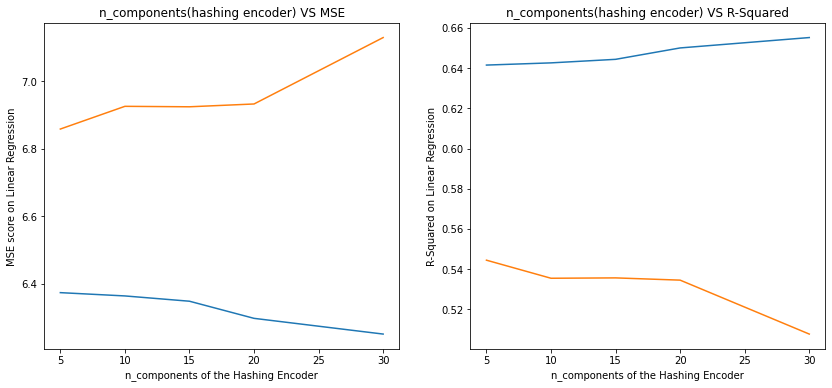

In [41]:
fig= plt.figure(figsize=(14,6))
gs= GridSpec(1,2, figure= fig)

ax1= fig.add_subplot(gs[0,0])
ax2= fig.add_subplot(gs[0,1])

ax1.plot(n_components,tr_rmse_score)
ax1.plot(n_components,cv_rmse_score)

ax2.plot(n_components,tr_r2_score)
ax2.plot(n_components,cv_r2_score)

ax1.title.set_text("n_components(hashing encoder) VS MSE")
ax1.set_xlabel("n_components of the Hashing Encoder")
ax1.set_ylabel("MSE score on Linear Regression")

ax2.title.set_text("n_components(hashing encoder) VS R-Squared")
ax2.set_xlabel("n_components of the Hashing Encoder")
ax2.set_ylabel("R-Squared on Linear Regression")

plt.show()

###From the above plot we see that the best n_components for the Hashing Encoder is n_components=5.

In [42]:
hash_encd_f= hs.HashingEncoder(n_components=5,hash_method='md5', cols=['County']).fit(train_x)
tr_x_h= hash_encd_f.transform(train_x)
cv_x_h= hash_encd_f.transform(cv_x)

pickle.dump(hash_encd_f,open('/content/drive/MyDrive/wheat_yield/hash_encd.pickle','wb'))

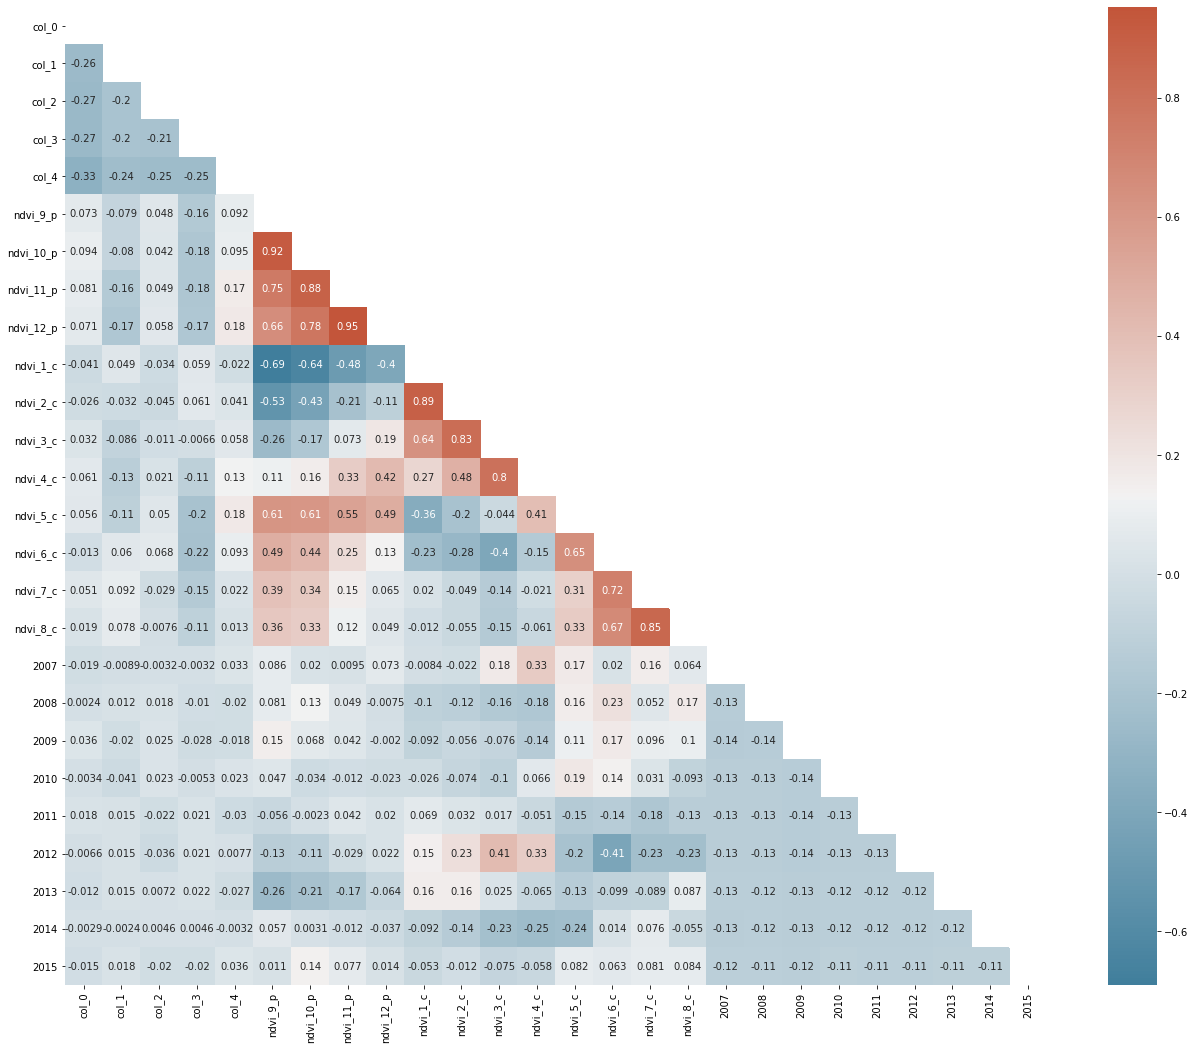

In [17]:
corr= tr_x_h.corr()
f, ax = plt.subplots(figsize=(22, 18))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
plt.show()

###Linear Regression

In [43]:
lin_regr= LinearRegression()
lin_regr.fit(tr_x_h,train_y)

pickle.dump(lin_regr,open('/content/drive/MyDrive/wheat_yield/lin_reg_model.pickle','wb'))

#lin_regr= pickle.load(open('/content/drive/MyDrive/wheat_yield/lin_reg_model.pickle', 'rb'))

tr_pred_lr= lin_regr.predict(tr_x_h)
cv_pred_lr= lin_regr.predict(cv_x_h)

print("The RMSE on the Train Data:",((mean_squared_error(train_y,tr_pred_lr)**0.5)))
print("The RMSE on the Train Data:",((mean_squared_error(cv_y,cv_pred_lr))**0.5))
print('='*100)
print("The R-Squared score on the Train Data:",(r2_score(train_y,tr_pred_lr)))
print("The R-Squared score on the Train Data:",(r2_score(cv_y,cv_pred_lr)))

The RMSE on the Train Data: 6.37345122283562
The RMSE on the Train Data: 6.858545281789203
The R-Squared score on the Train Data: 0.6415113093806792
The R-Squared score on the Train Data: 0.5444825462540301


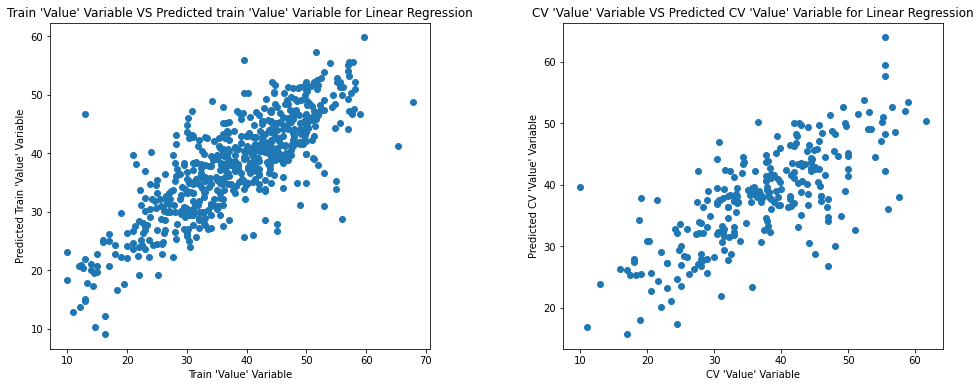

In [44]:
fig= plt.figure(figsize=(16,6))
gs= GridSpec(1,2,figure=fig)

ax1= fig.add_subplot(gs[0,0])
ax2= fig.add_subplot(gs[0,1])

ax1.scatter(train_y,tr_pred_lr)
ax2.scatter(cv_y,cv_pred_lr)

ax1.title.set_text("Train 'Value' Variable VS Predicted train 'Value' Variable for Linear Regression")
ax1.set_xlabel("Train 'Value' Variable")
ax1.set_ylabel("Predicted Train 'Value' Variable")

ax2.title.set_text("CV 'Value' Variable VS Predicted CV 'Value' Variable for Linear Regression")
ax2.set_xlabel("CV 'Value' Variable")
ax2.set_ylabel("Predicted CV 'Value' Variable")

plt.subplots_adjust(wspace=0.35)
plt.show()

##Lasso Regression

In [23]:
from sklearn.linear_model import Lasso
alpha = [0.0001,0.001, 0.01, 0.1, 1, 10]

tr_rmse_scores=[]
tr_r2_scores=[]

cv_rmse_scores=[]
cv_r2_scores=[]

for a in alpha:
    lasso_reg= Lasso(alpha=a)
    lasso_reg.fit(tr_x_h,train_y)

    tr_pred= lasso_reg.predict(tr_x_h)
    cv_pred= lasso_reg.predict(cv_x_h)

    tr_rmse_scores.append((mean_squared_error(train_y,tr_pred))**0.5)
    cv_rmse_scores.append((mean_squared_error(cv_y,cv_pred))**0.5)

    tr_r2_scores.append(r2_score(train_y,tr_pred))
    cv_r2_scores.append(r2_score(cv_y,cv_pred))

In [24]:
print(tr_rmse_scores)
print(cv_rmse_scores)
print(tr_r2_scores)
print(cv_r2_scores)

[6.371672688312481, 6.372419754744187, 6.438192813850382, 7.061727893897805, 10.435031905649419, 10.644786044679234]
[6.873740102847855, 6.866111201784608, 6.840088969030998, 7.334323785099387, 10.071731148480216, 10.208761284188391]
[0.6417113565858763, 0.6416273343445968, 0.6341912541478683, 0.5599033277462433, 0.03902146064767209, 0.0]
[0.542461950612172, 0.5434769949595375, 0.5469308382510816, 0.47909184215573597, 0.017688450538881018, -0.009222905706656404]


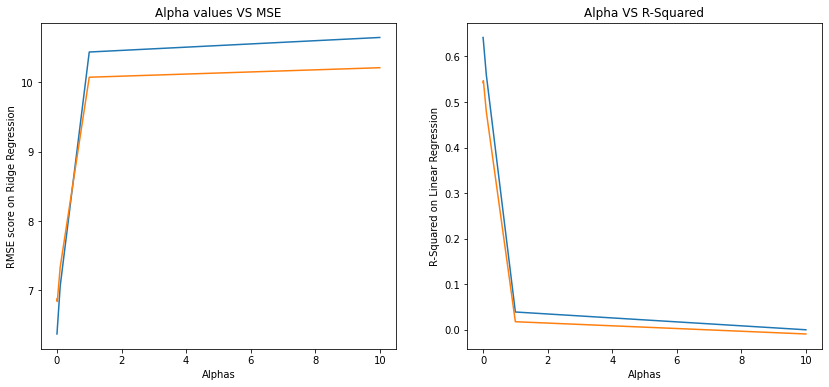

In [25]:
fig= plt.figure(figsize=(14,6))
gs= GridSpec(1,2, figure= fig)

ax1= fig.add_subplot(gs[0,0])
ax2= fig.add_subplot(gs[0,1])

ax1.plot(alpha,tr_rmse_scores)
ax1.plot(alpha,cv_rmse_scores)

ax2.plot(alpha,tr_r2_scores)
ax2.plot(alpha,cv_r2_scores)

ax1.title.set_text("Alpha values VS MSE")
ax1.set_xlabel("Alphas")
ax1.set_ylabel("RMSE score on Ridge Regression")

ax2.title.set_text("Alpha VS R-Squared")
ax2.set_xlabel("Alphas")
ax2.set_ylabel("R-Squared on Linear Regression")

plt.show()

In [27]:
best_lasso= Lasso(alpha=0.01)
best_lasso.fit(tr_x_h,train_y)
pickle.dump(best_lasso,open('/content/drive/MyDrive/wheat_yield/best_lasso_model.pickle','wb'))

tr_pred_lo= best_lasso.predict(tr_x_h)
cv_pred_lo= best_lasso.predict(cv_x_h)

print("The RMSE on the Train Data:",((mean_squared_error(train_y,tr_pred_lo)**0.5)))
print("The RMSE on the Train Data:",((mean_squared_error(cv_y,cv_pred_lo))**0.5))
print('='*100)
print("The R-Squared score on the Train Data:",(r2_score(train_y,tr_pred_lo)))
print("The R-Squared score on the Train Data:",(r2_score(cv_y,cv_pred_lo)))

The RMSE on the Train Data: 6.438192813850382
The RMSE on the Train Data: 6.840088969030998
The R-Squared score on the Train Data: 0.6341912541478683
The R-Squared score on the Train Data: 0.5469308382510816


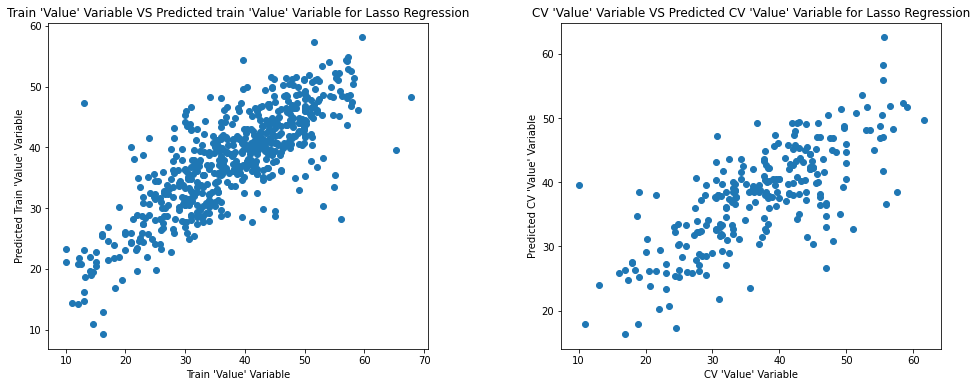

In [31]:
fig= plt.figure(figsize=(16,6))
gs= GridSpec(1,2,figure=fig)

ax1= fig.add_subplot(gs[0,0])
ax2= fig.add_subplot(gs[0,1])

ax1.scatter(train_y,tr_pred_lo)
ax2.scatter(cv_y,cv_pred_lo)

ax1.title.set_text("Train 'Value' Variable VS Predicted train 'Value' Variable for Lasso Regression")
ax1.set_xlabel("Train 'Value' Variable")
ax1.set_ylabel("Predicted Train 'Value' Variable")

ax2.title.set_text("CV 'Value' Variable VS Predicted CV 'Value' Variable for Lasso Regression")
ax2.set_xlabel("CV 'Value' Variable")
ax2.set_ylabel("Predicted CV 'Value' Variable")
plt.subplots_adjust(wspace=0.35)
plt.show()

In [66]:
tr_x_h.head()

,col_0,col_1,col_2,col_3,col_4,ndvi_9_p,ndvi_10_p,ndvi_11_p,ndvi_12_p,ndvi_1_c,ndvi_2_c,ndvi_3_c,ndvi_4_c,ndvi_5_c,ndvi_6_c,ndvi_7_c,ndvi_8_c,2007,2008,2009,2010,2011,2012,2013,2014,2015
739,0,1,0,0,0,0.284061,0.272344,0.272688,0.268243,0.327710,0.307342,0.358082,0.515966,0.690567,0.483694,0.293584,0.307256,0,1,0,0,0,0,0,0,0
140,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.741643,0.545904,0.611022,0.673862,0.559420,0.424718,0.393371,0.418662,0,0,0,0,0,0,0,1,0
173,0,0,0,0,1,0.283818,0.326698,0.470545,0.524720,0.484848,0.516332,0.583416,0.799038,0.831023,0.534318,0.427627,0.519115,0,0,0,0,0,0,1,0,0
6,1,0,0,0,0,0.299796,0.321373,0.318966,0.277785,0.300450,0.357596,0.444202,0.570541,0.647300,0.432768,0.361422,0.354220,0,0,0,0,0,0,0,0,1
552,1,0,0,0,0,0.360944,0.375996,0.499419,0.492139,0.428016,0.465513,0.578039,0.742835,0.766481,0.493085,0.422430,0.394222,0,0,1,0,0,0,0,0,0


##Random Forest Regressor

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [15, 30, 60],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [6, 8, 12],
    'n_estimators': [50, 80, 110]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10)
grid_search.fit(tr_x_h,train_y)
print("The best Parameters for a Random Forest Classifier is:",grid_search.best_params_)

The best Parameters for a Random Forest Classifier is: {'bootstrap': True, 'max_depth': 60, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 110}


In [46]:
best_rf= RandomForestRegressor(bootstrap= True, max_depth= 60, min_samples_leaf= 3, min_samples_split= 6, n_estimators= 110)
best_rf.fit(tr_x_h,train_y)

pickle.dump(best_rf,open('/content/drive/MyDrive/wheat_yield/best_rf_model.pickle','wb'))

tr_pred_rf= best_rf.predict(tr_x_h)
cv_pred_rf= best_rf.predict(cv_x_h)

print('Root Mean Sqauared Error on Train data',(mean_squared_error(train_y,tr_pred_rf))**0.5)
print('Root Mean Sqauared Error on CV data',(mean_squared_error(cv_y,cv_pred_rf))**0.5)
print('='*100)
print('R Squared value on Train data',r2_score(train_y,tr_pred_rf))
print('R Squared value on CV data',r2_score(cv_y,cv_pred_rf))

Root Mean Sqauared Error on Train data 3.1349830431729355
Root Mean Sqauared Error on CV data 5.468343369991042
R Squared value on Train data 0.9132645734236229
R Squared value on CV data 0.7104306736359072


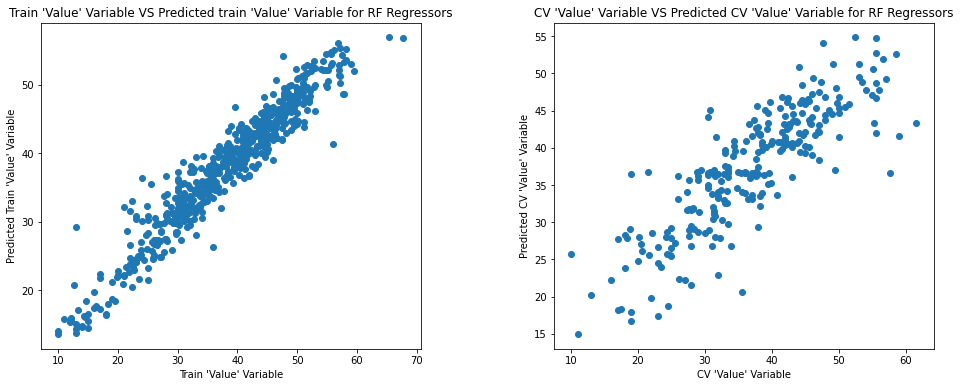

In [47]:
fig= plt.figure(figsize=(16,6))
gs= GridSpec(1,2,figure=fig)

ax1= fig.add_subplot(gs[0,0])
ax2= fig.add_subplot(gs[0,1])

ax1.scatter(train_y,tr_pred_rf)
ax2.scatter(cv_y,cv_pred_rf)

ax1.title.set_text("Train 'Value' Variable VS Predicted train 'Value' Variable for RF Regressors")
ax1.set_xlabel("Train 'Value' Variable")
ax1.set_ylabel("Predicted Train 'Value' Variable")

ax2.title.set_text("CV 'Value' Variable VS Predicted CV 'Value' Variable for RF Regressors")
ax2.set_xlabel("CV 'Value' Variable")
ax2.set_ylabel("Predicted CV 'Value' Variable")

plt.subplots_adjust(wspace=0.35)
plt.show()

##XGBoost Regressors

In [50]:
pip install xgboost

In [ ]:
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [20,40,80,100],
    'colsample_bytree': [0.3, 0.7],
    'max_depth': [3,7],
    'reg_alpha': [1.1,1.3],
    'reg_lambda': [1.1, 1.3],
    'subsample': [0.3,0.7]
}

xgb = XGBRegressor()

grid_search_xg = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 10)
grid_search_xg.fit(tr_x_h,train_y)

In [55]:
print("The best Parameters for a XG Boost Regressor is:",grid_search_xg.best_params_)

The best Parameters for a XG Boost Regressor is: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 80, 'reg_alpha': 1.3, 'reg_lambda': 1.1, 'subsample': 0.7}


In [64]:
best_xgb= XGBRegressor(colsample_bytree=0.7,max_depth= 7,n_estimators= 80, reg_alpha= 1.3, reg_lambda= 1.1, subsample= 0.7)
best_xgb.fit(tr_x_h,train_y)

pickle.dump(best_xgb,open('/content/drive/MyDrive/wheat_yield/best_xgb_model.pickle','wb'))

tr_pred_xgb= best_xgb.predict(tr_x_h)
cv_pred_xgb= best_xgb.predict(cv_x_h)

[14:01:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
print('Root Mean Sqauared Error on Train data',(mean_squared_error(train_y,tr_pred_xgb))**0.5)
print('Root Mean Sqauared Error on CV data',(mean_squared_error(cv_y,cv_pred_xgb))**0.5)
print('='*100)
print('R Squared value on Train data',r2_score(train_y,tr_pred_xgb))
print('R Squared value on CV data',r2_score(cv_y,cv_pred_xgb))

Root Mean Sqauared Error on Train data 1.3814085459754122
Root Mean Sqauared Error on CV data 5.375880516372541
R Squared value on Train data 0.9831589019897551
R Squared value on CV data 0.7201403950496955


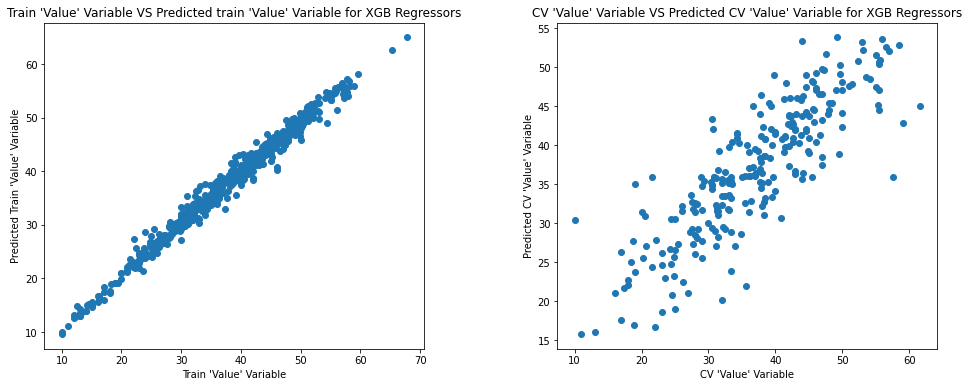

In [59]:
fig= plt.figure(figsize=(16,6))
gs= GridSpec(1,2,figure=fig)

ax1= fig.add_subplot(gs[0,0])
ax2= fig.add_subplot(gs[0,1])

ax1.scatter(train_y,tr_pred_xgb)
ax2.scatter(cv_y,cv_pred_xgb)

ax1.title.set_text("Train 'Value' Variable VS Predicted train 'Value' Variable for XGB Regressors")
ax1.set_xlabel("Train 'Value' Variable")
ax1.set_ylabel("Predicted Train 'Value' Variable")

ax2.title.set_text("CV 'Value' Variable VS Predicted CV 'Value' Variable for XGB Regressors")
ax2.set_xlabel("CV 'Value' Variable")
ax2.set_ylabel("Predicted CV 'Value' Variable")

plt.subplots_adjust(wspace=0.35)
plt.show()